In [1]:
%matplotlib inline

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


# Calculating Na I in mean models and prepping departure coefficients


First, we import everything we need. Lightweaver is typically imported as
`lw`, but things like the library of model atoms and Fal atmospheres need to
be imported separately.



In [3]:
import lightweaver as lw # Ovo ce ti dati svu funkcionalnost u smislu racunanja spektara, Ne-LTR i tako dalje 

from lightweaver.fal import Falc82 # ovo je jedan podrazumevani model atmosfere koji dolazi sa kodom
                                   # videcemo kako dole mozemo da uradimo druge stvari

from lightweaver.rh_atoms import H_6_atom, C_atom, O_atom, Si_atom, Al_atom, \
CaII_atom, Fe_atom, He_9_atom, MgII_atom, N_atom, NaI_fine_atom, S_atom # Specific atomic models that cover most of 
                                                                        # of the spectral lines studied in solar physccs 

import matplotlib.pyplot as plt
import time
import numpy as np

/home/milic/codes/Lightweaver/lightweaver/config.py:75: UserWarning: No config file found, using defaults. For optimised vectorised code, please run `lightweaver.benchmark()`, otherwise the most advanced instruction set supported by your machine will be picked, which may not be the fastest (due to e.g. aggressive AVX offsets).
  warnings.warn('No config file found, using defaults. For optimised vectorised code,'


In [4]:
# Synthesize a spectral line shape for given wavelength grid, not necessary for this thing but nice to have

def synth(atmos, conserve, useNe, wave, prd):
    
    '''
    Synthesise a spectral line for given atmosphere with different conditions.
    
    By default we use conserve = False  useNe = False 
    

    Parameters
    ----------
    atmos : lw.Atmosphere - The atmospheric model in which to synthesise the line.
    
    conserve : bool - Whether to start from LTE electron density and conserve charge, or simply use from the electron density present in the atmospheric model.
    
    useNe : bool Whether to use the electron density present in the model as the starting solution, or compute the LTE electron density.
    
    wave : np.ndarray Array of wavelengths over which to resynthesise the final line profile for muz=1.

    Returns
    -------
    ctx : lw.Context -The Context object that was used to compute the equilibrium populations - what is this?
    
    Iwave : np.ndarray - The intensity at muz=1 for each wavelength in `wave`. How to do a mu that is not = 1?
    '''
    
    # Configure the atmospheric angular quadrature - only matters for NLTE 
    atmos.quadrature(3)
    
    # Configure the set of atomic models to use.
    aSet = lw.RadiativeSet([H_6_atom(), C_atom(), O_atom(), Si_atom(), Al_atom(), CaII_atom(), Fe_atom(), He_9_atom(), MgII_atom(), N_atom(), NaI_fine_atom(), S_atom()])
    
    # Set H and Ca to "active" i.e. NLTE, everything else participates as an
    # LTE background.
    aSet.set_active('Na')
    
    # Compute the necessary wavelength dependent information (SpectrumConfiguration).
    spect = aSet.compute_wavelength_grid()

    # Either compute the equilibrium populations at the fixed electron density
    # provided in the model, or iterate an LTE electron density and compute the
    # corresponding equilibrium populations (SpeciesStateTable).
    
    if useNe:
        eqPops = aSet.compute_eq_pops(atmos)
    else:
        eqPops = aSet.iterate_lte_ne_eq_pops(atmos)

    # Configure the Context which holds the state of the simulation for the  backend, and provides the python interface to the backend.
    # Feel free to increase Nthreads to increase the number of threads the program will use.
    
    ctx = lw.Context(atmos, spect, eqPops, conserveCharge=conserve, Nthreads=1)
    
    # Iterate the Context to convergence (using the iteration function now
    # provided by Lightweaver)
    
    lw.iterate_ctx_se(ctx, prd=prd)
    
    # Update the background populations based on the converged solution and
    # compute the final intensity for mu=1 on the provided wavelength grid.
    eqPops.update_lte_atoms_Hmin_pops(atmos)
    
    mu_emergent = 1.0
    
    Iwave = ctx.compute_rays(wave, [mu_emergent], stokes=True) # Calculate emergent spectrum in the direction mu_emergent
                                                                # at the wavelength grid wave 
                                                                # either only the intensity or full Stokes 
    return ctx, Iwave

The wavelength grid to output the final synthesised line on.



In [5]:
wave = np.linspace(588.8, 589.8, 1001)

In [6]:
# Load a snapi atmosphere:
#atmoss = np.loadtxt("/home/milic/codes/snapi/cfg/falc.dat",unpack=True, skiprows=1)

# Load a firtez atmosphere
#atmoss = np.loadtxt("/home/milic/codes/snapi/cfg/falc.dat",unpack=True, skiprows=1)
#atmoss = np.loadtxt("/home/milic/data/fontenla_2009_models/VALCIII_fine_short", skiprows=1,unpack=True)
#atmoss.shape
#Nz = atmoss.shape[1]
#print("info: total number of depth points: ", Nz)

In [7]:
#z = atmoss[0]*1E3
#T = atmoss[3]
#vturb = atmoss[6]*1E3
#pgas = atmoss[5]*10.0
#vz = np.zeros(Nz)

In [8]:
# our atmos model is by default the Falc one that was supplied with the code
atmos = Falc82()

In [9]:
atmos.temperature.shape

(82,)

In [11]:
atmos.B  = np.ones(82) * 0.2

In [13]:
atmos.chiB = np.ones(82) 
atmos.gammaB = np.zeros(82)

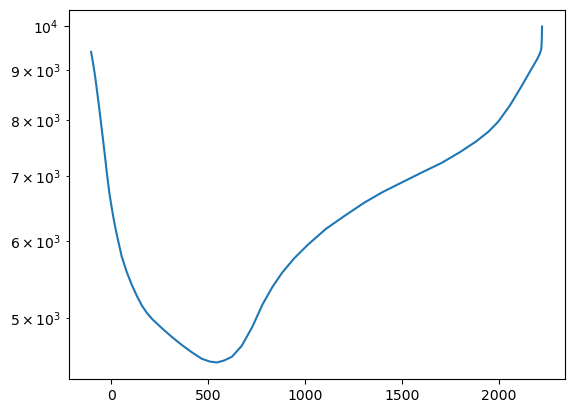

In [14]:
# For practice, we plot the structure of the atmosphere:

plt.semilogy(atmos.z[25:]/1E3, atmos.temperature[25:])

In [15]:
%%time
#atmos= lw.Atmosphere.make_1d(lw.atmosphere.ScaleType.Geometric, np.copy(z), np.copy(T), np.copy(vz), np.copy(vturb), Pgas=pgas)

ctx, I = synth(atmos, conserve=False, useNe=False, wave=wave*1.000293, prd=False)

-- Iteration 0:
dJ = 1.00e+00
    (Lambda iterating background)
-- Iteration 10:
dJ = 6.07e-02
    Na delta = 3.2557e-02
-- Iteration 19:
dJ = 1.54e-02
    Na delta = 7.4369e-03
-- Iteration 29:
dJ = 2.96e-03
    Na delta = 1.3591e-03
--------------------------------------------------------------------------------
Final Iteration: 31
--------------------------------------------------------------------------------
dJ = 2.10e-03
    Na delta = 9.6047e-04
--------------------------------------------------------------------------------
Context converged to statistical equilibrium in 31 iterations after 1.16 s.
--------------------------------------------------------------------------------
LTE Iterations 1 (-- slowest convergence)
CPU times: user 3.02 s, sys: 0 ns, total: 3.02 s
Wall time: 3.03 s


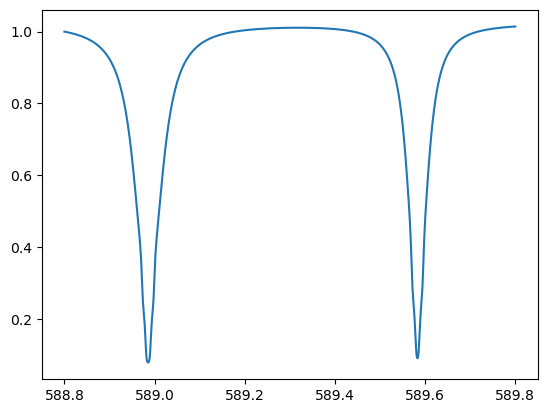

In [20]:
plt.plot(wave, I[0]/I[0,0])

In [21]:
#snapi_spec = np.loadtxt("/home/milic/data/cfg_min/valc3c_fine_short_na_synth.dat",unpack=True)
atlas = np.loadtxt("na_5893_10.dat",unpack=True)

In [22]:
atlas[1] *= np.amax(I)/np.amax(atlas[1])

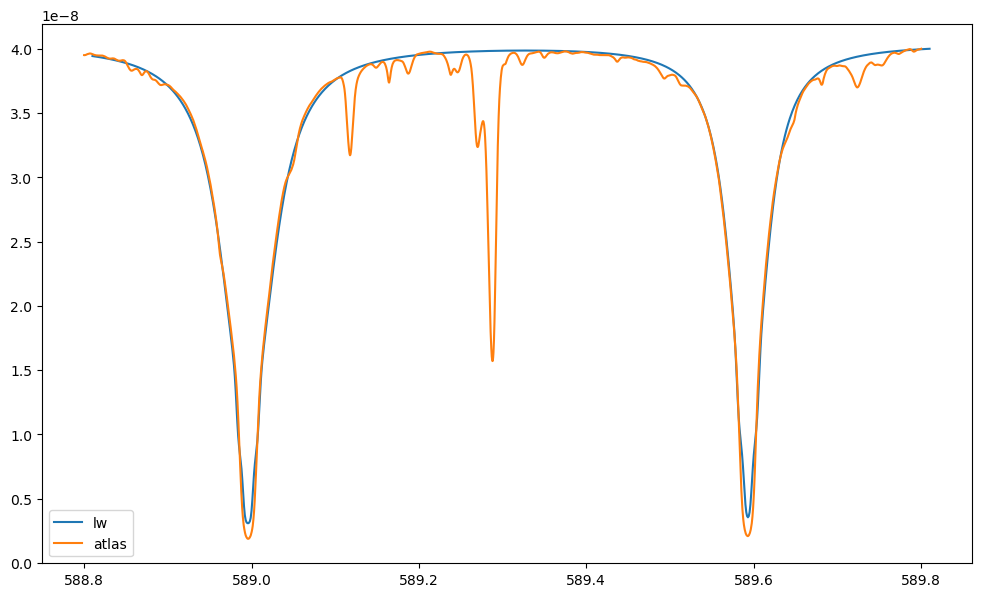

In [24]:
plt.figure(figsize=[12,7])
plt.plot(wave+0.01,I[0], label='lw')
plt.plot(atlas[0]/10, atlas[1], label='atlas')
plt.legend()

## Now let's do the same for Mg I atom for b2 line

In [26]:
from lightweaver.rh_atoms import MgI_atom

In [69]:
# Synthesize a spectral line shape for given wavelength grid, not necessary for this thing but nice to have

def synth(atmos, conserve, useNe, wave, prd):
    
    '''
    Synthesise a spectral line for given atmosphere with different conditions.

    Parameters
    ----------
    atmos : lw.Atmosphere - The atmospheric model in which to synthesise the line.
    
    conserve : bool - Whether to start from LTE electron density and conserve charge, or simply use from the electron density present in the atmospheric model.
    
    useNe : bool Whether to use the electron density present in the model as the starting solution, or compute the LTE electron density.
    
    wave : np.ndarray Array of wavelengths over which to resynthesise the final line profile for muz=1.

    Returns
    -------
    ctx : lw.Context -The Context object that was used to compute the equilibrium populations - what is this?
    
    Iwave : np.ndarray - The intensity at muz=1 for each wavelength in `wave`. How to do a mu that is not = 1?
    '''
    
    # Configure the atmospheric angular quadrature
    atmos.quadrature(5)
    # Configure the set of atomic models to use.
    aSet = lw.RadiativeSet([H_6_atom(), C_atom(), O_atom(), Si_atom(), Al_atom(), CaII_atom(), Fe_atom(), He_9_atom(), MgI_atom(), N_atom(), NaI_fine_atom(), S_atom()])
    
    # Set H and Ca to "active" i.e. NLTE, everything else participates as an
    # LTE background.
    aSet.set_active('Mg')
    
    # Compute the necessary wavelength dependent information (SpectrumConfiguration).
    spect = aSet.compute_wavelength_grid()

    # Either compute the equilibrium populations at the fixed electron density
    # provided in the model, or iterate an LTE electron density and compute the
    # corresponding equilibrium populations (SpeciesStateTable).
    
    if useNe:
        eqPops = aSet.compute_eq_pops(atmos)
    else:
        eqPops = aSet.iterate_lte_ne_eq_pops(atmos)

    # Configure the Context which holds the state of the simulation for the  backend, and provides the python interface to the backend.
    # Feel free to increase Nthreads to increase the number of threads the program will use.
    
    ctx = lw.Context(atmos, spect, eqPops, conserveCharge=conserve, Nthreads=1)
    
    # Iterate the Context to convergence (using the iteration function now
    # provided by Lightweaver)
    
    lw.iterate_ctx_se(ctx, prd=prd)
    
    # Update the background populations based on the converged solution and
    # compute the final intensity for mu=1 on the provided wavelength grid.
    
    eqPops.update_lte_atoms_Hmin_pops(atmos)
    Iwave = ctx.compute_rays(wave, [1.0], stokes=True)
    return ctx, Iwave

In [34]:
wave = np.linspace(516.7, 517.75, 1051)

In [70]:
ctx, I = synth(atmos, conserve=False, useNe=False, wave=wave*1.000293, prd=False)

NameError: name 'MgI_atom' is not defined

(0.0, 1.1)

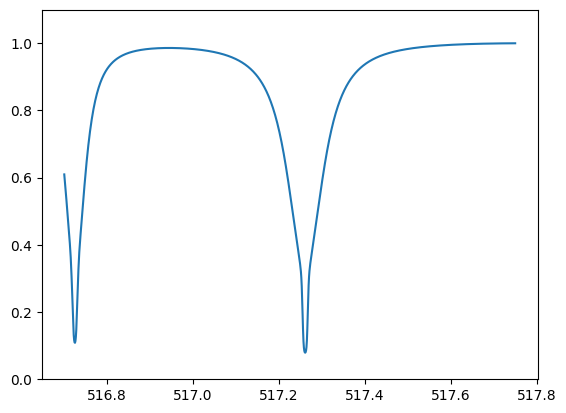

In [33]:
plt.plot(wave, I/np.amax(I))
plt.ylim([0,1.1])

In [34]:
atlas = np.loadtxt("/home/milic/data/atlas_regions/5172_10.txt",unpack=True)

In [35]:
atlas[0]

array([5167.   , 5167.002, 5167.004, ..., 5176.996, 5176.998, 5177.   ])

In [36]:
sc = np.loadtxt("/home/milic/data/cfg_min/valc3c_fine_short_mg_synth.dat",unpack=True)

In [37]:
sc[0]

array([5.16700000e-05, 5.16700999e-05, 5.16701998e-05, ...,
       5.17697003e-05, 5.17698002e-05, 5.17700000e-05])

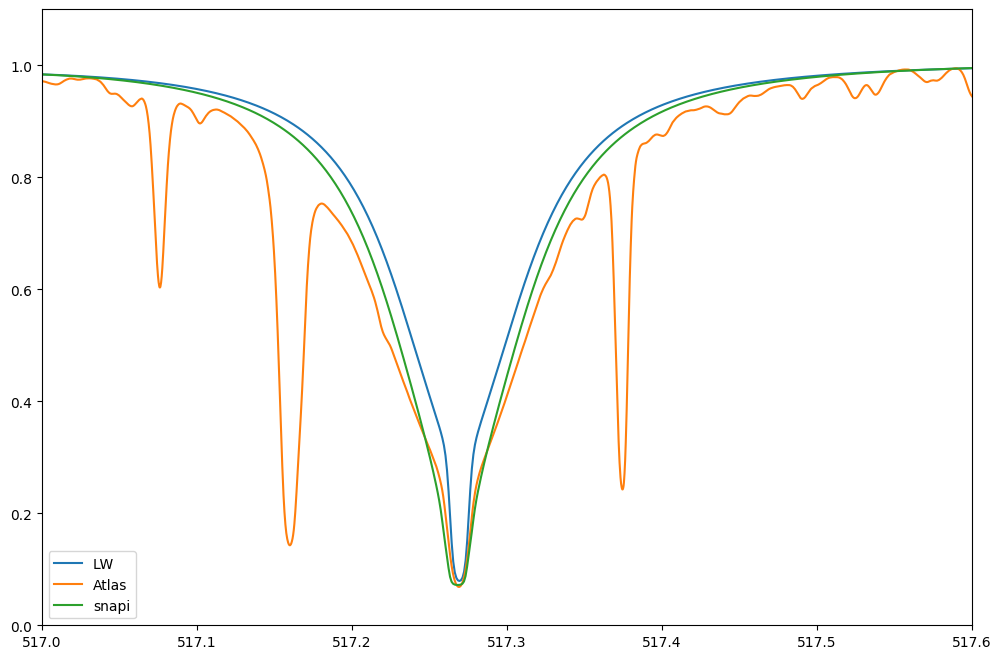

In [42]:
plt.figure(figsize=[12,8])
plt.plot(wave+0.0085, I/np.amax(I), label = 'LW ')
plt.plot(atlas[0]/10.0, atlas[1]/np.amax(atlas[1]), label = 'Atlas')
plt.plot(sc[0]*1E7, sc[1]/np.amax(sc[1]), label = 'snapi')
plt.ylim([0,1.1])
plt.xlim([517,517.6])
plt.legend()